<div style="border:solid grey 2px; padding: 20px"> 

# Analyzing borrowers’ risk of defaulting

Your project is to prepare a report for a bank’s loan division. You’ll need to find out if a customer’s marital status and number of children has an impact on whether they will default on a loan. The bank already has some data on customers’ credit worthiness.

Your report will be considered when building a **credit scoring** of a potential customer. A ** credit scoring ** is used to evaluate the ability of a potential borrower to repay their loan.

## Open the data file and have a look at the general information. 

In [96]:
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
import nltk
from nltk.stem import WordNetLemmatizer
import seaborn as sns
warnings.simplefilter(action='ignore')

In [97]:
credit_df = pd.read_csv("/datasets/credit_scoring_eng.csv")
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


* there is incomplete data in the 'days_employed' and 'total_income' columns.

### study the data:

In [98]:
print("children column: value_counts \n\n", credit_df['children'].value_counts())
print("\n-----------------------------------------------")
print("\ndays_employed column: sort_values \n\n", credit_df['days_employed'].dropna().sort_values())
print("\n-----------------------------------------------")
print("\ndob_years column: count \n\n", credit_df.groupby('dob_years')['dob_years'].count())
print("\n-----------------------------------------------")
print("\neducation column: value_counts \n\n", credit_df['education'].value_counts())

credit_df['education_id'].value_counts()
credit_df['family_status'].value_counts()
credit_df['family_status_id'].value_counts()
credit_df['gender'].value_counts()
credit_df['income_type'].value_counts()
credit_df['debt'].value_counts()
credit_df['total_income'].dropna().sort_values()
credit_df['purpose'].value_counts()
print()

children column: value_counts 

  0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

-----------------------------------------------

days_employed column: sort_values 

 16335    -18388.949901
4299     -17615.563266
7329     -16593.472817
17838    -16264.699501
16825    -16119.687737
             ...      
7794     401663.850046
2156     401674.466633
7664     401675.093434
10006    401715.811749
6954     401755.400475
Name: days_employed, Length: 19351, dtype: float64

-----------------------------------------------

dob_years column: count 

 dob_years
0     101
19     14
20     51
21    111
22    183
23    254
24    264
25    357
26    408
27    493
28    503
29    545
30    540
31    560
32    510
33    581
34    603
35    617
36    555
37    537
38    598
39    573
40    609
41    607
42    597
43    513
44    547
45    497
46    475
47    480
48    538
49    508
50    514
51    448
52    484
53    

1. cildren: there are 2 anomalies, most probably relult of a human input error. I will change -1 to 1, and 20 to 2.
2. days_employed: there are 2174 NaN values and more corrupt data with negetive values, I will change days to years and try to fill missing values.
3. dob_years: there are 101 pople aged 0, will change it to NaN and drop later.
4. education: the string is writen in different variations, need to .lower() and clean.
5. education_id, family_status, family_status_id, gender, income_type, debt and total_income: looking good.
6. purpose: will use SnowballStemmer and/or WordNetLemmatizer to creat more general purpose categories.

## Data preprocessing
### Processing missing values

In [99]:
def children_fix(row):
    children = row['children']
    
    if children == -1:
        return 1
    if children == 20:
        return 2
    return children 

def years_work_fix(row):
    age = row['dob_years']
    years = abs(row['days_employed'])/365.242199

    if pd.isna(years) == True:
        return float('NaN')
    if years >= age:
        return - years
    return years 

def years_work_grouped(row):
    years = row['years_employed_fix']
    
    if years < 0:
        return -1
    if pd.isna(years) == True:
        return 0
    if years <= 10:
        return 1
    if years <= 20:
        return 2
    if years <= 30:
        return 3
    if years <= 40:
        return 4
    if years <= 50:
        return 5
    return 6

def negetive_fix(row):
    years = row['years_employed']   
    if years < 0:
        return years/(-100)
    return years

def age_fix(row):
    age = row['dob_years']
    
    if age == 0:
        return float('NaN')
    return age 

In [100]:
credit_df['children'] = credit_df.apply( children_fix , axis=1) 
credit_df['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

* children numbers look plausible.

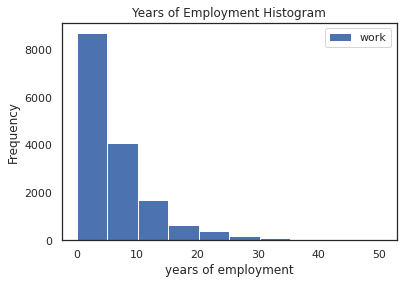

In [101]:
credit_df['years_employed'] = credit_df.apply( years_work_fix , axis=1)
plt_data = credit_df[credit_df['years_employed']>=0 ]['years_employed']
plt.hist(plt_data, label='work')
plt.gca().set(title='Years of Employment Histogram', ylabel='Frequency', xlabel='years of employment')
plt.legend();

* Years of Employment distrebution look logical.

* there are 3519 negetive values out of 19351 enteries (~18%). i would like to find a way to use them.

In [102]:
credit_df['years_employed_fix'] = credit_df.apply( negetive_fix , axis=1) 
credit_df['years_work_grouped'] = credit_df.apply( years_work_grouped , axis=1) 
credit_df['years_work_grouped'].value_counts()

1    14496
2     4104
0     2174
3      574
4      160
5       16
6        1
Name: years_work_grouped, dtype: int64

In [103]:
credit_df['dob_years'] = credit_df.apply( age_fix , axis=1) 
credit_df['education'] = credit_df['education'].str.lower()
credit_df['education'].value_counts()

secondary education    15233
bachelor's degree       5260
some college             744
primary education        282
graduate degree            6
Name: education, dtype: int64

In [104]:
credit_df.head(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,years_employed_fix,years_work_grouped
0,1,-8437.673028,42.0,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house,23.101583,23.101583,3
1,1,-4024.803754,36.0,secondary education,1,married,0,F,employee,0,17932.802,car purchase,11.019547,11.019547,2
2,0,-5623.422610,33.0,secondary education,1,married,0,M,employee,0,23341.752,purchase of the house,15.396421,15.396421,2


* The data clean and ready for work.

### Data type replacement

In [105]:
credit_df['total_income'].dropna().sort_values()

14585      3306.762
13006      3392.845
16174      3418.824
1598       3471.216
14276      3503.298
            ...    
17178    273809.483
20809    274402.943
9169     276204.162
19606    352136.354
12412    362496.645
Name: total_income, Length: 19351, dtype: float64

In [106]:
def total_income_grouped(row):
    income = row['total_income']
    
    if pd.isna(income) == True:
        return float('NaN')
    if income <= 10000:
        return 1
    if income <= 20000:
        return 2
    if income <= 30000:
        return 3
    if income <= 40000:
        return 4
    if income <= 50000:
        return 5
    if income <= 60000:
        return 6
    if income <= 70000:
        return 7
    if income <= 80000:
        return 8
    if income <= 90000:
        return 9
    return 10

In [107]:
credit_df['total_income_grouped'] = credit_df.apply( total_income_grouped , axis=1) 
credit_df.groupby('total_income_grouped')['total_income'].count()

total_income_grouped
1.0      926
2.0     6443
3.0     6063
4.0     3107
5.0     1492
6.0      648
7.0      294
8.0      156
9.0       83
10.0     139
Name: total_income, dtype: int64

In [108]:
print("Number of different loan purposes:", len(credit_df['purpose'].value_counts()))

Number of different loan purposes: 38


* the purpose for loan is messy, need to make broader categories.

In [109]:
wordnet_lemma = WordNetLemmatizer() 

def purpose_grouped(row):
    purpose = row['purpose']
    words = nltk.word_tokenize(purpose)
    lemmas = [wordnet_lemma.lemmatize(w, pos = 'n') for w in words]
    
    housing = ['house', 'housing', 'estate', 'property' ]       #1
    car = ['car']                                               #2
    education = ['education' , 'educated', 'university']        #3
    wedding = ['wedding' ]                                      #4 
 
    if any(item in housing for item in lemmas):
        return 'housing'
    if any(item in car for item in lemmas):
        return 'car'
    if any(item in education for item in lemmas):
        return 'education'
    if any(item in wedding for item in lemmas):
        return 'wedding'
    print(lemmas) 
    return -1

credit_df['purpose_grouped'] = credit_df.apply( purpose_grouped , axis=1) 
credit_df['purpose_grouped'].value_counts()

housing      10840
car           4315
education     4022
wedding       2348
Name: purpose_grouped, dtype: int64

In [110]:
credit_df.head(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,years_employed_fix,years_work_grouped,total_income_grouped,purpose_grouped
0,1,-8437.673028,42.0,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house,23.101583,23.101583,3,5.0,housing
1,1,-4024.803754,36.0,secondary education,1,married,0,F,employee,0,17932.802,car purchase,11.019547,11.019547,2,2.0,car
2,0,-5623.422610,33.0,secondary education,1,married,0,M,employee,0,23341.752,purchase of the house,15.396421,15.396421,2,3.0,housing


* We made general groups for loan based on purpose.
* We grouped by income and years worked.

### Processing duplicates

In [111]:
credit_df = credit_df.drop_duplicates() 

* we have cleared 71 duplicates.


## Answer questions abot the data

### Is there a relation between having kids and repaying a loan on time?

In [113]:
def children_yn(row):
    children = row['children']
    
    if children == 0:
        return 0
    return 1

credit_df['children_yn'] = credit_df.apply( children_yn , axis=1) 

# i chose to count 'gender' because there is no Nulls in it.
debt_all = credit_df[credit_df['debt'] == 1 ]['gender'].count()/ credit_df['gender'].count()
debt_children = credit_df[(credit_df['debt'] == 1 ) & (credit_df['children_yn'] == 1 )]['gender'].count()/credit_df[credit_df['children_yn'] == 1]['gender'].count()
ratio = debt_children/debt_all

print("precent of people with debt out of all: {:.2f}%".format(debt_all*100))
print("precent of people with debt out of people with children: {:.2f}%".format(debt_children*100))
print("people with children are {:.2f}% more likly to defaulted on a loan.".format(ratio*100 -100))

precent of people with debt out of all: 8.12%
precent of people with debt out of people with children: 9.21%
people with children are 13.47% more likly to defaulted on a loan.


* people with children are 13.47% more likly to defaulted on a loan.

### Is there a relation between marital status and repaying a loan on time?

In [114]:
print((credit_df[credit_df['debt'] == 1 ]['family_status'].value_counts()/(credit_df['family_status'].value_counts()*debt_all)).sort_values(ascending = False))

unmarried            1.201583
civil partnership    1.151830
married              0.929778
divorced             0.876517
widow / widower      0.809527
Name: family_status, dtype: float64


* yes there is a relation between marital status and repaying a loan on time, unmerried are the worst at repaying a loan on time,
while widow / widower are the best at repaying a loan on time in relation to the whole population.


### Is there a relation between income level and repaying a loan on time?

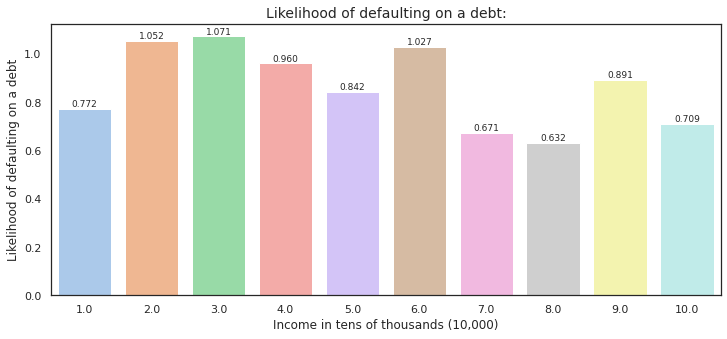

In [115]:
all_grouped = credit_df.groupby('total_income_grouped')['total_income'].count()
debt_grouped = credit_df[credit_df['debt'] == 1].groupby('total_income_grouped')['total_income'].count()
df = pd.DataFrame(debt_grouped/(all_grouped*debt_all)).reset_index()

sns.set(style='white')
plt.figure(figsize=(12, 5))
ax = sns.barplot(x='total_income_grouped', y='total_income', data=df, ci=None, palette=sns.color_palette('pastel'))

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                   bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0, 5),
                   textcoords='offset points')
    
plt.title('Likelihood of defaulting on a debt:', size=14)
plt.xlabel("Income in tens of thousands (10,000)", size=12)
plt.ylabel('Likelihood of defaulting on a debt', size=12)
plt.show();

* It seems like people that earn less than 10,000 a month are better at repaying loans on time in relation to the whole population.
    
* It also seems like people that earn more than 60,000 a month are better at repaying loans on time in relation to the whole population.


### How do different loan purposes affect on-time repayment of the loan?

In [116]:
purposes_grouped = credit_df.groupby('purpose_grouped')['purpose_grouped'].count()
purposes_debt_grouped = credit_df[credit_df['debt'] == 1].groupby('purpose_grouped')['purpose_grouped'].count()
print(purposes_debt_grouped/(purposes_grouped*debt_all))

purpose_grouped
car          1.153295
education    1.136167
housing      0.891354
wedding      0.986248
Name: purpose_grouped, dtype: float64


* It seems like people that take a loan for housing purposes tend to repaying loans on time in relation to the whole population.
    
* It seems like people that take a loan for car/education purposes tend to not repaying loans on time in relation to the whole population.

## General conclusion

* There are alot of parameters that can determin the liklihood of borrower to defualt on his debt.
* The more data parameters we have and more then we can make better predictions.
* For the data that we have present we can detarmin that the safest candidate for a loan is: 
1. Childless widow /widower 
2. Earn more than 60,000. 
3. Loan purpose: housing.

* There are 8 of those individuals in our data.